<p style="align: center;"><img src="https://static.tildacdn.com/tild6636-3531-4239-b465-376364646465/Deep_Learning_School.png" width="400"></p>

# Глубокое обучение. Часть 2
# Домашнее задание по теме "Механизм внимания"

Это домашнее задание проходит в формате peer-review. Это означает, что его будут проверять ваши однокурсники. Поэтому пишите разборчивый код, добавляйте комментарии и пишите выводы после проделанной работы.

В этом задании вы будете решать задачу классификации математических задач по темам (многоклассовая классификация) с помощью Transformer.

В качестве датасета возьмем датасет математических задач по разным темам. Нам необходим следующий файл:

[Файл с классами](https://docs.google.com/spreadsheets/d/13YIbphbWc62sfa-bCh8MLQWKizaXbQK9/edit?usp=drive_link&ouid=104379615679964018037&rtpof=true&sd=true)

**Hint:** не перезаписывайте модели, которые вы получите на каждом из этапов этого дз. Они ещё понадобятся.

### Задание 1 (2 балла)

Напишите кастомный класс для модели трансформера для задачи классификации, использующей в качествке backbone какую-то из моделей huggingface.

Т.е. конструктор класса должен принимать на вход название модели и подгружать её из huggingface, а затем использовать в качестве backbone (достаточно возможности использовать в качестве backbone те модели, которые упомянуты в последующих пунктах)

In [1]:
import torch
import torch.nn as nn
from transformers import AutoModel, AutoConfig
from typing import Union

class TransformerClassificationModel(nn.Module):
    def __init__(self, base_transformer_model: Union[str, nn.Module], dropout: float, num_classes: int):
        super().__init__()

        if isinstance(base_transformer_model, str):
            self.backbone = AutoModel.from_pretrained(base_transformer_model)
        else:
            self.backbone = base_transformer_model

        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(self.backbone.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.backbone(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0, :]
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        return {"logits": logits}

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Задание 2 (1 балл)

Напишите функцию заморозки backbone у модели (если необходимо, возвращайте из функции модель)

In [3]:
def freeze_backbone_func(model: TransformerClassificationModel) -> TransformerClassificationModel:
    for param in model.backbone.parameters():
        param.requires_grad = False
    return model

### Задание 3 (2 балла)

Напишите функцию, которая будет использована для тренировки (дообучения) трансформера (TransformerClassificationModel). Функция должна поддерживать обучение с замороженным и размороженным backbone.

In [5]:
import copy
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
from tqdm import tqdm

class TransformerTrainer:
    def __init__(self, transformer_model: TransformerClassificationModel, train_loader, val_loader,
                 epochs: int = 3, learning_rate: float = 2e-5, freeze_backbone: bool = True):
        self.model = copy.deepcopy(transformer_model)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.freeze_backbone = freeze_backbone

        if self.freeze_backbone:
            self.model = freeze_backbone_func(self.model)

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model.to(self.device)

        self.optimizer = AdamW(self.model.parameters(), lr=self.learning_rate)
        total_steps = len(self.train_loader) * self.epochs
        self.scheduler = get_linear_schedule_with_warmup(self.optimizer, num_warmup_steps=0, num_training_steps=total_steps)

    def train(self):
        for epoch in range(self.epochs):
            self.model.train()
            train_loss = 0
            train_progress_bar = tqdm(self.train_loader, desc=f"Epoch {epoch+1}/{self.epochs} - Training")

            for batch in train_progress_bar:
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                labels = batch['labels'].to(self.device)

                self.optimizer.zero_grad()
                outputs = self.model(input_ids, attention_mask)
                loss = torch.nn.functional.cross_entropy(outputs['logits'], labels)
                loss.backward()
                self.optimizer.step()
                self.scheduler.step()

                train_loss += loss.item()
                train_progress_bar.set_postfix({'loss': loss.item()})

            train_loss /= len(self.train_loader)

            self.model.eval()
            val_loss = 0
            val_accuracy = 0
            val_progress_bar = tqdm(self.val_loader, desc=f"Epoch {epoch+1}/{self.epochs} - Validation")

            with torch.no_grad():
                for batch in val_progress_bar:
                    input_ids = batch['input_ids'].to(self.device)
                    attention_mask = batch['attention_mask'].to(self.device)
                    labels = batch['labels'].to(self.device)

                    outputs = self.model(input_ids, attention_mask)
                    loss = torch.nn.functional.cross_entropy(outputs['logits'], labels)
                    val_loss += loss.item()

                    predictions = torch.argmax(outputs['logits'], dim=1)
                    val_accuracy += (predictions == labels).sum().item()

                    val_progress_bar.set_postfix({'loss': loss.item(), 'accuracy': val_accuracy / len(self.val_loader.dataset)})

            val_loss /= len(self.val_loader)
            val_accuracy /= len(self.val_loader.dataset)

            print(f"\nEpoch {epoch+1}/{self.epochs} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f} - Val Accuracy: {val_accuracy:.4f}")

        return self.model

### Задание 4 (1 балл)

Проверьте вашу функцию из предыдущего пункта, дообучив двумя способами
*cointegrated/rubert-tiny2* из huggingface.

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Загрузка данных
data_path = "/content/drive/MyDrive/data_problems.xlsx"
data = pd.read_excel(data_path)

# Определение названий столбцов с текстом и метками
text_column = 'Задача'
label_column = 'Тема'

# Разделение данных на тренировочный и проверочный наборы
train_df, val_df = train_test_split(data, test_size=0.2, random_state=42)

# Определение количества классов
num_classes = data[label_column].nunique()

from torch.utils.data import Dataset

class TextDataset(Dataset):
    def __init__(self, dataframe, tokenizer, text_column, label_column, max_len=512):
        self.tokenizer = tokenizer
        self.text = dataframe[text_column].values
        self.labels = pd.Categorical(dataframe[label_column]).codes
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, idx):
        text = str(self.text[idx])
        inputs = self.tokenizer(text, max_length=self.max_len, padding='max_length', truncation=True, return_tensors="pt")
        input_ids = inputs['input_ids'].squeeze()
        attention_mask = inputs['attention_mask'].squeeze()
        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }


In [10]:
from transformers import AutoTokenizer

# Загрузка токенизатора
tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")


train_dataset = TextDataset(train_df, tokenizer, text_column, label_column)
val_dataset = TextDataset(val_df, tokenizer, text_column, label_column)


train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)


# Создание модели
rubert_tiny_transformer_model = TransformerClassificationModel("cointegrated/rubert-tiny2", dropout=0.1, num_classes=num_classes)

# Дообучение модели с замороженным backbone
trainer = TransformerTrainer(rubert_tiny_transformer_model, train_loader, val_loader, epochs=3, learning_rate=2e-5, freeze_backbone=True)
rubert_tiny_finetuned_with_freezed_backbone = trainer.train()

# Создание новой модели для полного дообучения
rubert_tiny_transformer_model = TransformerClassificationModel("cointegrated/rubert-tiny2", dropout=0.1, num_classes=num_classes)

# Полное дообучение модели
trainer = TransformerTrainer(rubert_tiny_transformer_model, train_loader, val_loader, epochs=3, learning_rate=2e-5, freeze_backbone=False)
rubert_tiny_full_finetuned = trainer.train()

config.json:   0%|          | 0.00/693 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/118M [00:00<?, ?B/s]

Epoch 1/3 - Validation: 100%|██████████| 66/66 [00:05<00:00, 12.15it/s, loss=1.84, accuracy=0.323]



Epoch 1/3 - Train Loss: 1.9129 - Val Loss: 1.8443 - Val Accuracy: 0.3232


Epoch 2/3 - Validation: 100%|██████████| 66/66 [00:03<00:00, 17.56it/s, loss=1.78, accuracy=0.397]



Epoch 2/3 - Train Loss: 1.7975 - Val Loss: 1.7787 - Val Accuracy: 0.3972


Epoch 3/3 - Validation: 100%|██████████| 66/66 [00:03<00:00, 19.61it/s, loss=1.77, accuracy=0.408]



Epoch 3/3 - Train Loss: 1.7509 - Val Loss: 1.7599 - Val Accuracy: 0.4076


Epoch 1/3 - Validation: 100%|██████████| 66/66 [00:03<00:00, 19.78it/s, loss=1.51, accuracy=0.564]



Epoch 1/3 - Train Loss: 1.3812 - Val Loss: 1.1811 - Val Accuracy: 0.5640


Epoch 2/3 - Validation: 100%|██████████| 66/66 [00:03<00:00, 19.68it/s, loss=1.3, accuracy=0.592]



Epoch 2/3 - Train Loss: 1.1014 - Val Loss: 1.0664 - Val Accuracy: 0.5924


Epoch 3/3 - Validation: 100%|██████████| 66/66 [00:03<00:00, 19.44it/s, loss=1.29, accuracy=0.601]


Epoch 3/3 - Train Loss: 1.0243 - Val Loss: 1.0479 - Val Accuracy: 0.6009


### Задание 5 (1 балл)

Обучите *tbs17/MathBert* (с замороженным backbone и без заморозки), проанализируйте результаты. Сравните скоры с первым заданием. Получилось лучше или нет? Почему?

In [11]:
from transformers import AutoTokenizer

# Загрузка токенизатора и создание модели MathBert
tokenizer = AutoTokenizer.from_pretrained("tbs17/MathBert")

train_dataset = TextDataset(train_df, tokenizer, text_column, label_column)
val_dataset = TextDataset(val_df, tokenizer, text_column, label_column)


train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)



mathbert_transformer_model = TransformerClassificationModel("tbs17/MathBert", dropout=0.1, num_classes=num_classes)

# Дообучение модели MathBert с замороженным backbone
trainer = TransformerTrainer(mathbert_transformer_model, train_loader, val_loader, epochs=3, learning_rate=2e-5, freeze_backbone=True)
mathbert_finetuned_with_freezed_backbone = trainer.train()

# Создание новой модели MathBert для полного дообучения
mathbert_transformer_model = TransformerClassificationModel("tbs17/MathBert", dropout=0.1, num_classes=num_classes)

# Полное дообучение модели MathBert
trainer = TransformerTrainer(mathbert_transformer_model, train_loader, val_loader, epochs=3, learning_rate=2e-5, freeze_backbone=False)
mathbert_full_finetuned = trainer.train()

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/569 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/441M [00:00<?, ?B/s]

Epoch 1/3 - Validation: 100%|██████████| 66/66 [00:35<00:00,  1.83it/s, loss=1.71, accuracy=0.432]



Epoch 1/3 - Train Loss: 1.8646 - Val Loss: 1.6637 - Val Accuracy: 0.4322


Epoch 2/3 - Validation: 100%|██████████| 66/66 [00:36<00:00,  1.83it/s, loss=1.7, accuracy=0.439]



Epoch 2/3 - Train Loss: 1.6385 - Val Loss: 1.6353 - Val Accuracy: 0.4389


Epoch 3/3 - Validation: 100%|██████████| 66/66 [00:36<00:00,  1.83it/s, loss=1.7, accuracy=0.44]



Epoch 3/3 - Train Loss: 1.6154 - Val Loss: 1.6310 - Val Accuracy: 0.4398


Epoch 1/3 - Validation: 100%|██████████| 66/66 [00:35<00:00,  1.84it/s, loss=1.41, accuracy=0.555]



Epoch 1/3 - Train Loss: 1.3542 - Val Loss: 1.1939 - Val Accuracy: 0.5545


Epoch 2/3 - Validation: 100%|██████████| 66/66 [00:36<00:00,  1.83it/s, loss=1.06, accuracy=0.589]



Epoch 2/3 - Train Loss: 1.0608 - Val Loss: 1.1092 - Val Accuracy: 0.5886


Epoch 3/3 - Validation: 100%|██████████| 66/66 [00:36<00:00,  1.83it/s, loss=1.04, accuracy=0.584]


Epoch 3/3 - Train Loss: 0.9282 - Val Loss: 1.0947 - Val Accuracy: 0.5839


## Сравнивая результаты дообучения моделей RuBERT-Tiny2 и MathBERT, можно сделать следующие выводы:

### Дообучение с замороженным backbone:
- RuBERT-Tiny2: Достигнута точность (Val Accuracy) 0.4076 после 3 эпох обучения.
- MathBERT: Достигнута точность (Val Accuracy) 0.4398 после 3 эпох обучения.
- MathBERT показал немного лучшую точность по сравнению с RuBERT-Tiny2 при дообучении с замороженным backbone.

### Полное дообучение (без заморозки backbone):
- RuBERT-Tiny2: Достигнута точность (Val Accuracy) 0.6009 после 3 эпох обучения.
- MathBERT: Достигнута точность (Val Accuracy) 0.5839 после 3 эпох обучения.
- RuBERT-Tiny2 показал лучшую точность по сравнению с MathBERT при полном дообучении.

Таким образом, при дообучении с замороженным backbone модель MathBERT показала немного лучшие результаты, чем RuBERT-Tiny2. Однако при полном дообучении модель RuBERT-Tiny2 превзошла MathBERT по точности.

### Возможные причины таких результатов:

- Размер и архитектура моделей: MathBERT может иметь большую емкость и более сложную архитектуру по сравнению с RuBERT-Tiny2, что позволяет ему лучше адаптироваться к задаче классификации при дообучении с замороженным backbone.

- Предобученность моделей: MathBERT, вероятно, был предобучен на математических текстах, что может давать ему преимущество при работе с математическими задачами по сравнению с общей моделью RuBERT-Tiny2.

### Задание 6 (1 балл)

Напишите функцию для отрисовки карт внимания первого слоя для моделей из задания

In [20]:
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertModel
from typing import List

class AttentionMapVisualizer:
    def __init__(self, model: TransformerClassificationModel):
        self.model = model
        self.tokenizer = BertTokenizer.from_pretrained(model.backbone.config._name_or_path)

    def _get_attention_maps(self, text: str, device: torch.device):
        # Токенизация текста
        inputs = self.tokenizer(text, return_tensors="pt")

        # Перенос входных данных на указанное устройство
        inputs = {k: v.to(device) for k, v in inputs.items()}

        # Получение скрытых состояний и матрицы внимания
        with torch.no_grad():
            outputs = self.model.backbone(**inputs, output_attentions=True)
            attentions = outputs.attentions

        return attentions

    def _plot_attention_maps(self, attentions, attention_head_ids: List[int], inputs):
        # Получение матрицы внимания для первого слоя
        first_layer_attention = attentions[0]

        # Количество голов внимания в первом слое
        num_attention_heads = first_layer_attention.shape[1]

        # Отрисовка карт внимания для выбранных голов внимания
        num_selected_heads = len(attention_head_ids)
        fig, axs = plt.subplots(1, num_selected_heads, figsize=(20, 5))

        for i, head_id in enumerate(attention_head_ids):
            attention_map = first_layer_attention[0, head_id].cpu().numpy()
            ax = axs[i] if num_selected_heads > 1 else axs
            im = ax.imshow(attention_map, cmap='viridis', vmin=0, vmax=1)
            ax.set_xticks(range(len(inputs['input_ids'][0])))
            ax.set_yticks(range(len(inputs['input_ids'][0])))
            ax.set_xticklabels(self.tokenizer.convert_ids_to_tokens(inputs["input_ids"][0]), rotation=45, ha='right')
            ax.set_yticklabels(self.tokenizer.convert_ids_to_tokens(inputs["input_ids"][0]))
            ax.set_title(f"Head {head_id}")

        fig.subplots_adjust(right=0.8)
        cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
        fig.colorbar(im, cax=cbar_ax)

        plt.suptitle("Attention Maps - First Layer")
        plt.tight_layout()
        plt.show()

    def visualize_attention_maps(self, attention_head_ids: List[int], text: str, device: torch.device):
        attentions = self._get_attention_maps(text, device)
        inputs = self.tokenizer(text, return_tensors="pt")
        inputs = {k: v.to(device) for k, v in inputs.items()}
        self._plot_attention_maps(attentions, attention_head_ids, inputs)

### Задание 7 (1 балл)

Проведите инференс для всех моделей **ДО ДООБУЧЕНИЯ** на 2-3 текстах из датасета. Посмотрите на головы Attention первого слоя в каждой модели на выбранных текстах (отрисуйте их отдельно).

Попробуйте их проинтерпретировать. Какие связи улавливают карты внимания? (если в модели много голов Attention, то проинтерпретируйте наиболее интересные)

RuBERT-Tiny2 Attention Maps:
Text: Между девятью планетами Солнечной системы введено космическое сообщение.  Ракеты летают по следующим маршрутам: Земля – Меркурий, Плутон – Венера, Земля – Плутон, Плутон – Меркурий, Меркурий – Венера, Уран – Нептун, Нептун – Сатурн, Сатурн – Юпитер, Юпитер – Марс и Марс – Уран. Можно ли добраться с Земли до Марса? 


<ipython-input-12-2ff30800c240>:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


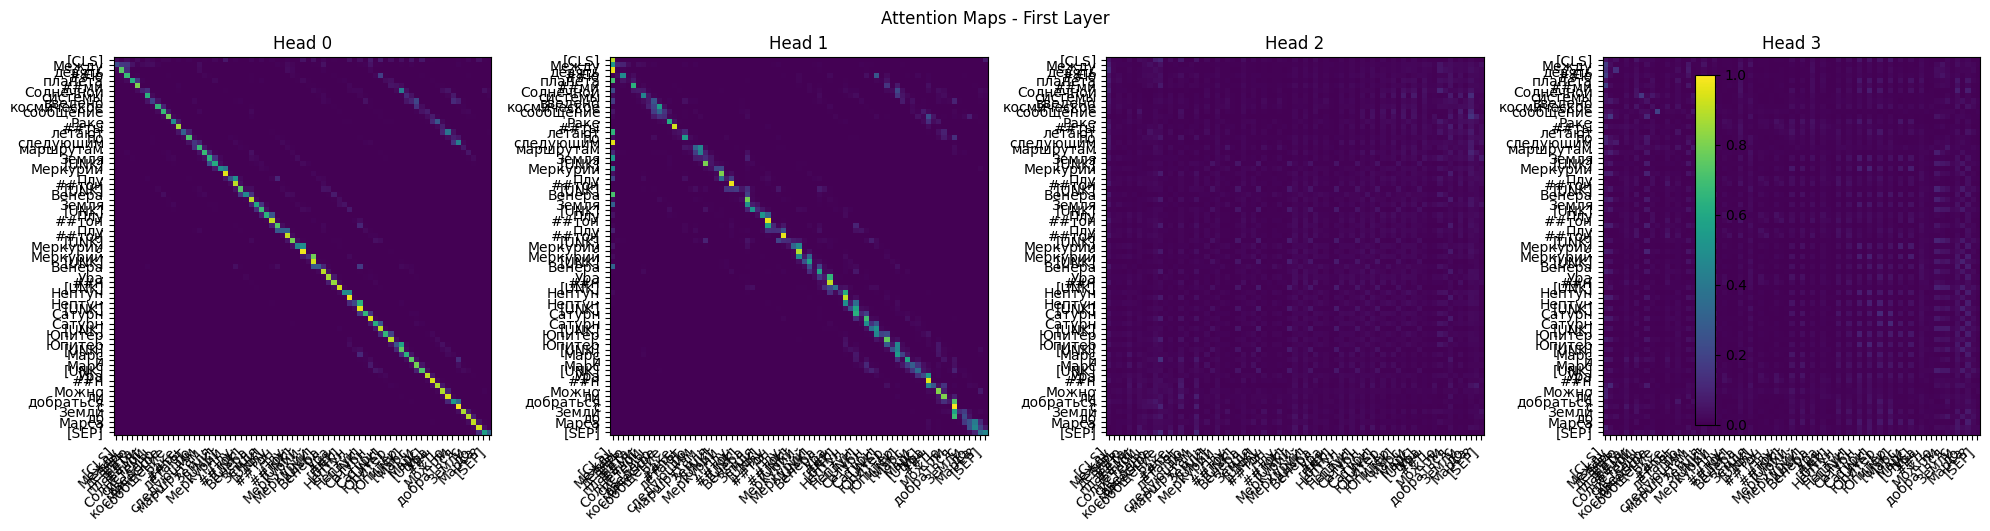


Text: В квадрате отметили 20 точек и соединили их непересекающимися отрезками друг с другом и с вершинами квадрата так, что квадрат разбился на треугольники. Сколько получилось треугольников? 


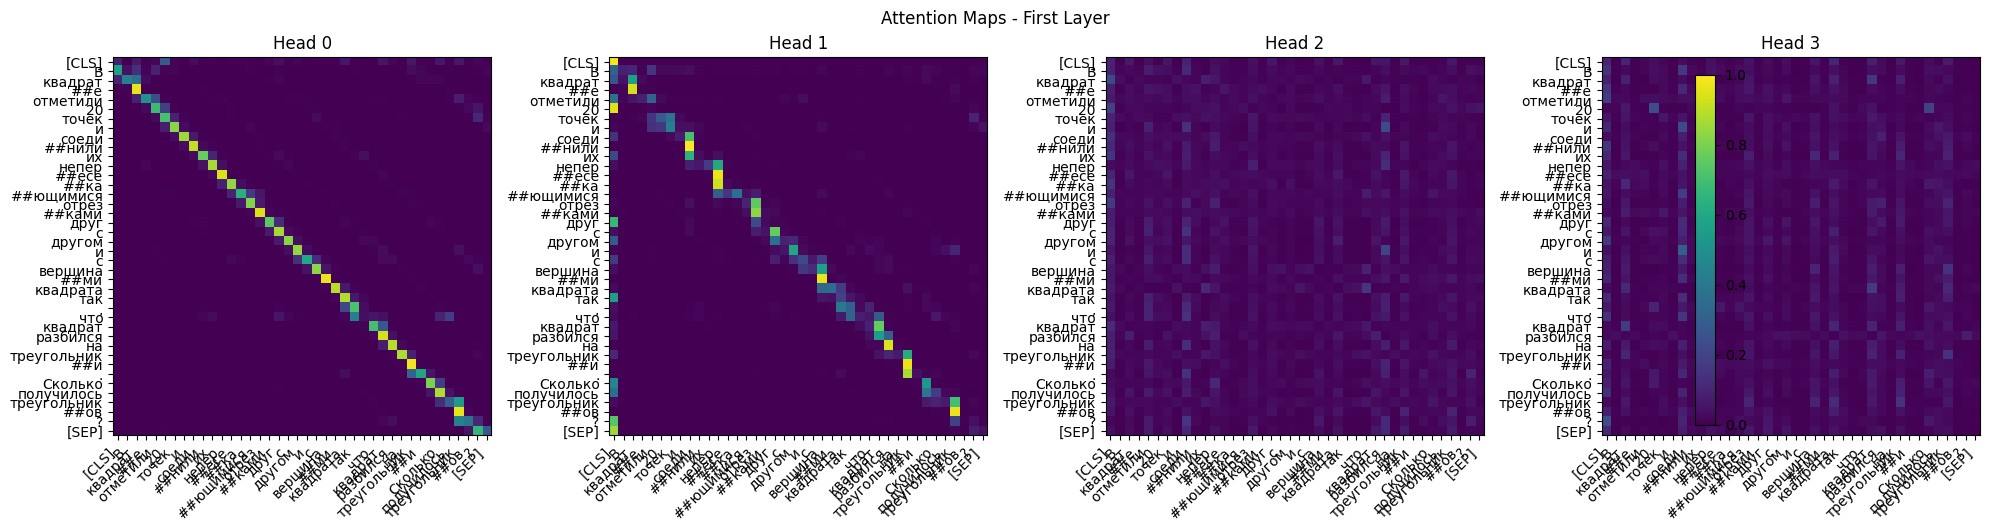


Text: Художник-авангардист нарисовал картину "Контур квадрата и его диагонали". 
Мог ли он нарисовать свою картину, не отрывая карандаша от бумаги и не проводя одну линию дважды? 


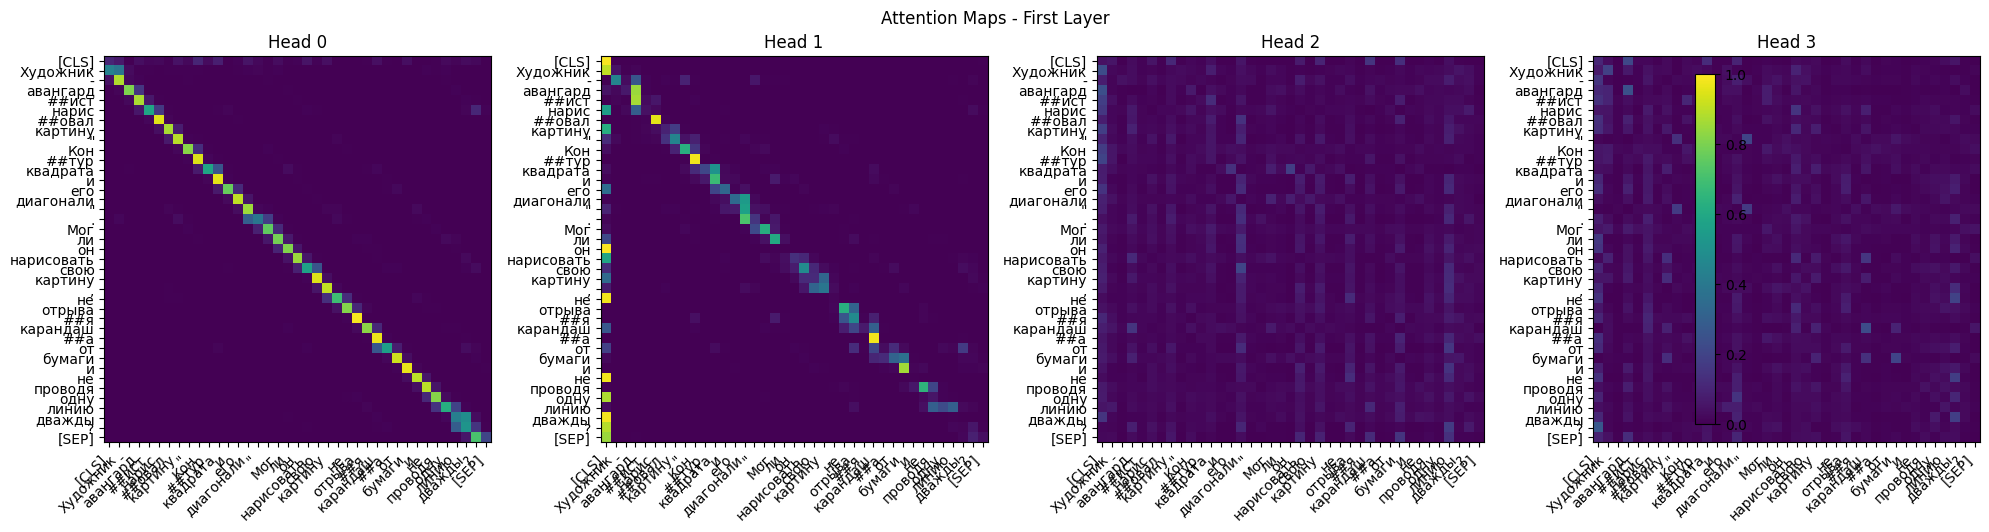


MathBERT Attention Maps:
Text: Между девятью планетами Солнечной системы введено космическое сообщение.  Ракеты летают по следующим маршрутам: Земля – Меркурий, Плутон – Венера, Земля – Плутон, Плутон – Меркурий, Меркурий – Венера, Уран – Нептун, Нептун – Сатурн, Сатурн – Юпитер, Юпитер – Марс и Марс – Уран. Можно ли добраться с Земли до Марса? 


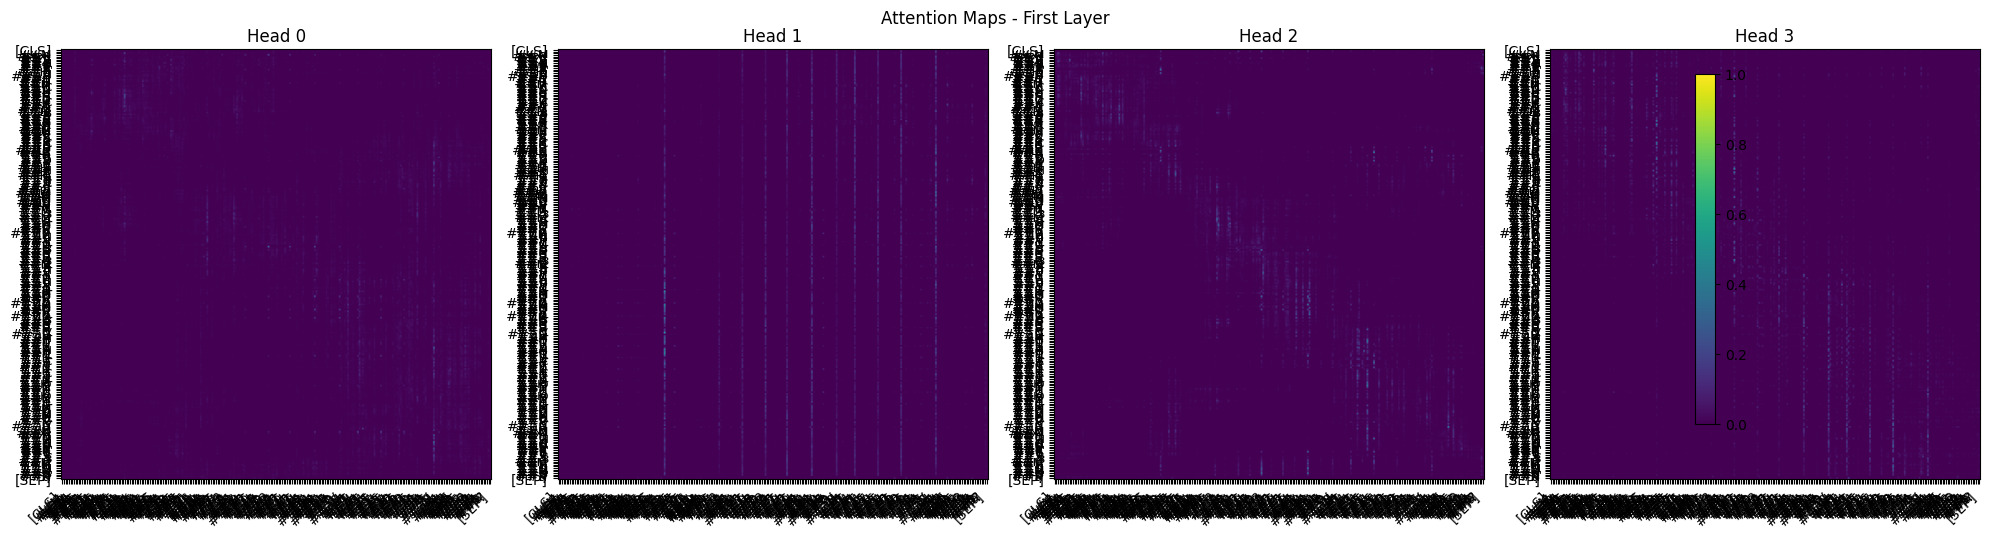


Text: В квадрате отметили 20 точек и соединили их непересекающимися отрезками друг с другом и с вершинами квадрата так, что квадрат разбился на треугольники. Сколько получилось треугольников? 


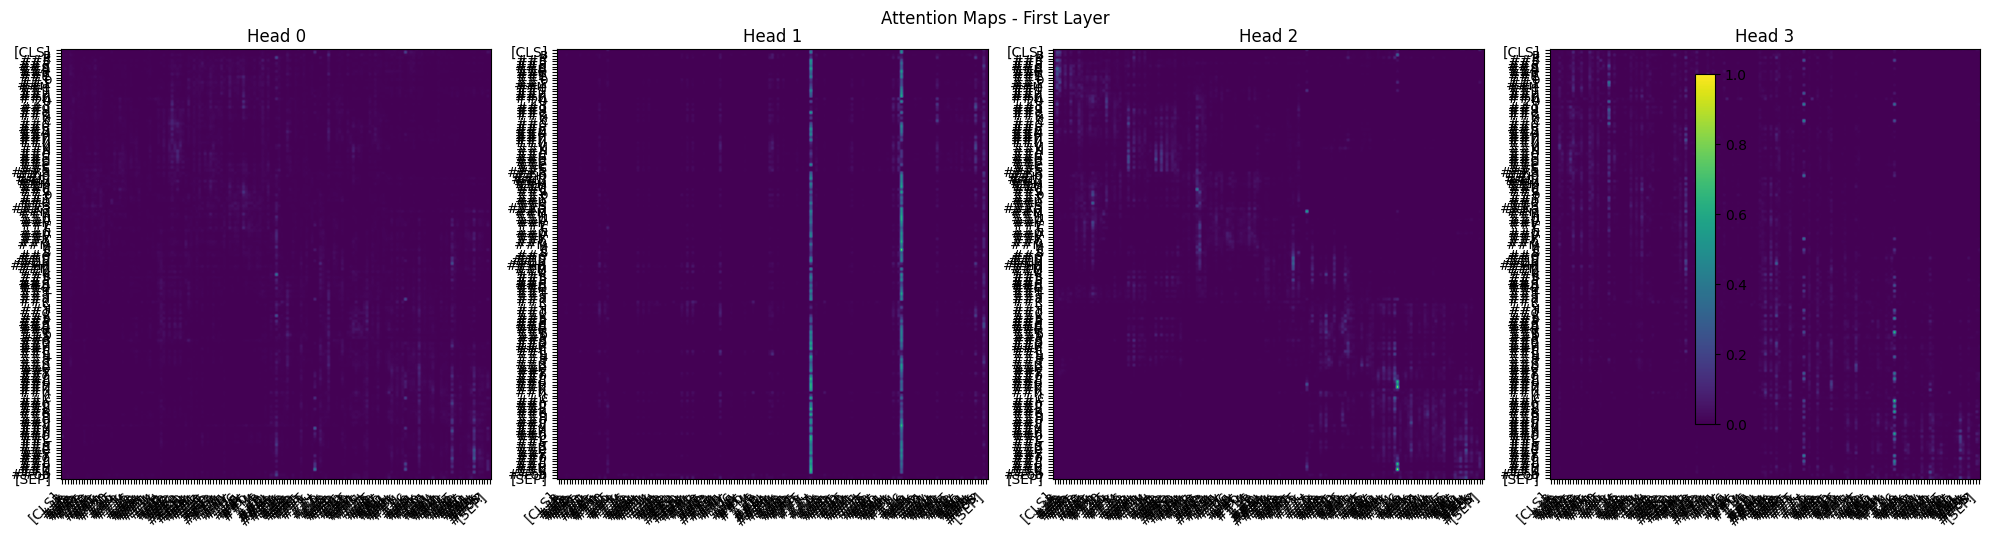


Text: Художник-авангардист нарисовал картину "Контур квадрата и его диагонали". 
Мог ли он нарисовать свою картину, не отрывая карандаша от бумаги и не проводя одну линию дважды? 


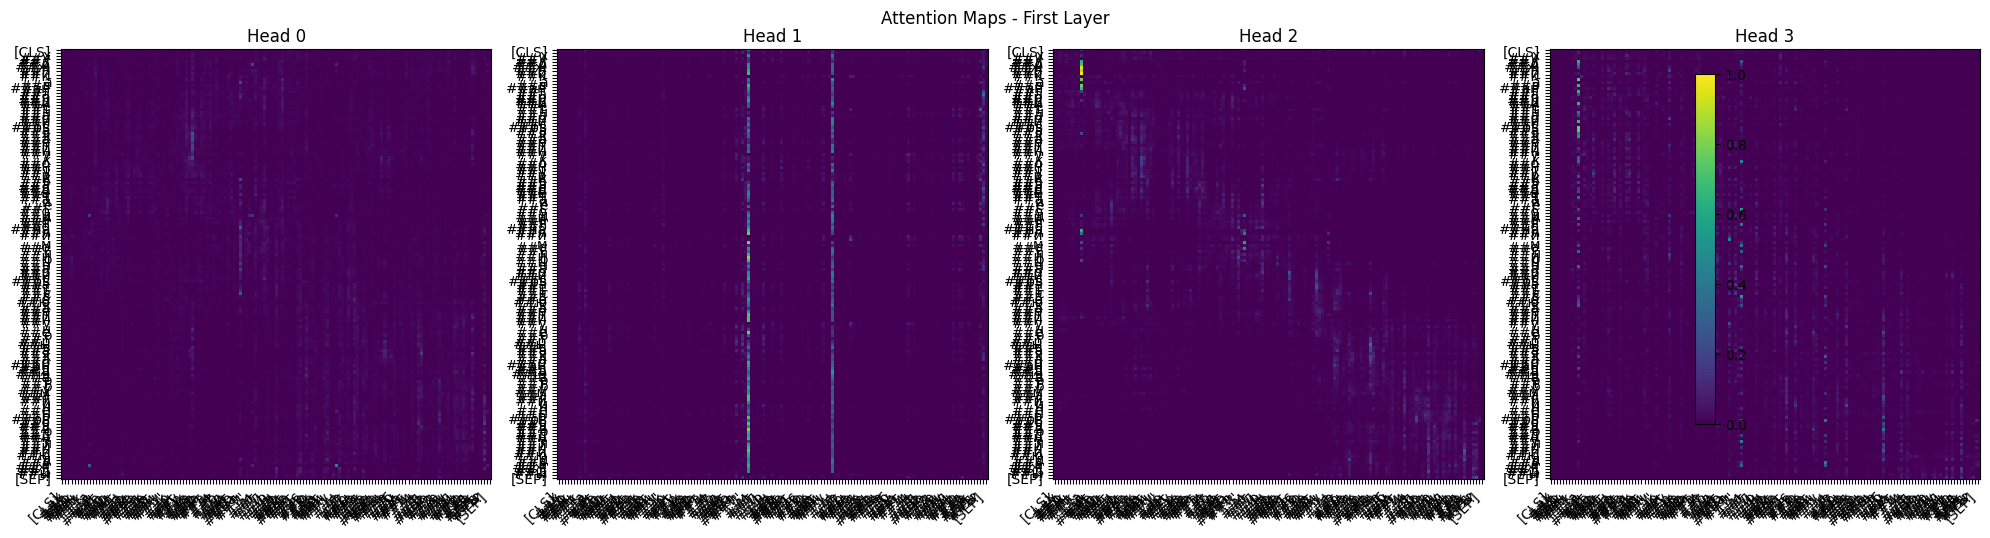

In [14]:
# Создание моделей до дообучения
rubert_tiny_model = TransformerClassificationModel("cointegrated/rubert-tiny2", dropout=0.1, num_classes=num_classes)
mathbert_model = TransformerClassificationModel("tbs17/MathBert", dropout=0.1, num_classes=num_classes)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Выбор нескольких текстов из датасета
texts = [
    data['Задача'][0],
    data['Задача'][100],
    data['Задача'][200]
]


# Идентификаторы голов внимания для отрисовки
attention_head_ids = [0, 1, 2, 3]

# Визуализация карт внимания для RuBERT-Tiny2
print("RuBERT-Tiny2 Attention Maps:")
rubert_visualizer = AttentionMapVisualizer(rubert_tiny_model)
for text in texts:
    print("Text:", text)
    rubert_visualizer.visualize_attention_maps(attention_head_ids, text, device)
    print()

# Визуализация карт внимания для MathBERT
print("MathBERT Attention Maps:")
mathbert_visualizer = AttentionMapVisualizer(mathbert_model)
for text in texts:
    print("Text:", text)
    mathbert_visualizer.visualize_attention_maps(attention_head_ids, text, device)
    print()

### Задание 8 (1 балл)

Сделайте то же самое для дообученных моделей. Изменились ли карты внимания и связи, которые они улавливают? Почему?

Fine-tuned RuBERT-Tiny2 Attention Maps:
Text: Между девятью планетами Солнечной системы введено космическое сообщение.  Ракеты летают по следующим маршрутам: Земля – Меркурий, Плутон – Венера, Земля – Плутон, Плутон – Меркурий, Меркурий – Венера, Уран – Нептун, Нептун – Сатурн, Сатурн – Юпитер, Юпитер – Марс и Марс – Уран. Можно ли добраться с Земли до Марса? 


<ipython-input-20-e2b17919f207>:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


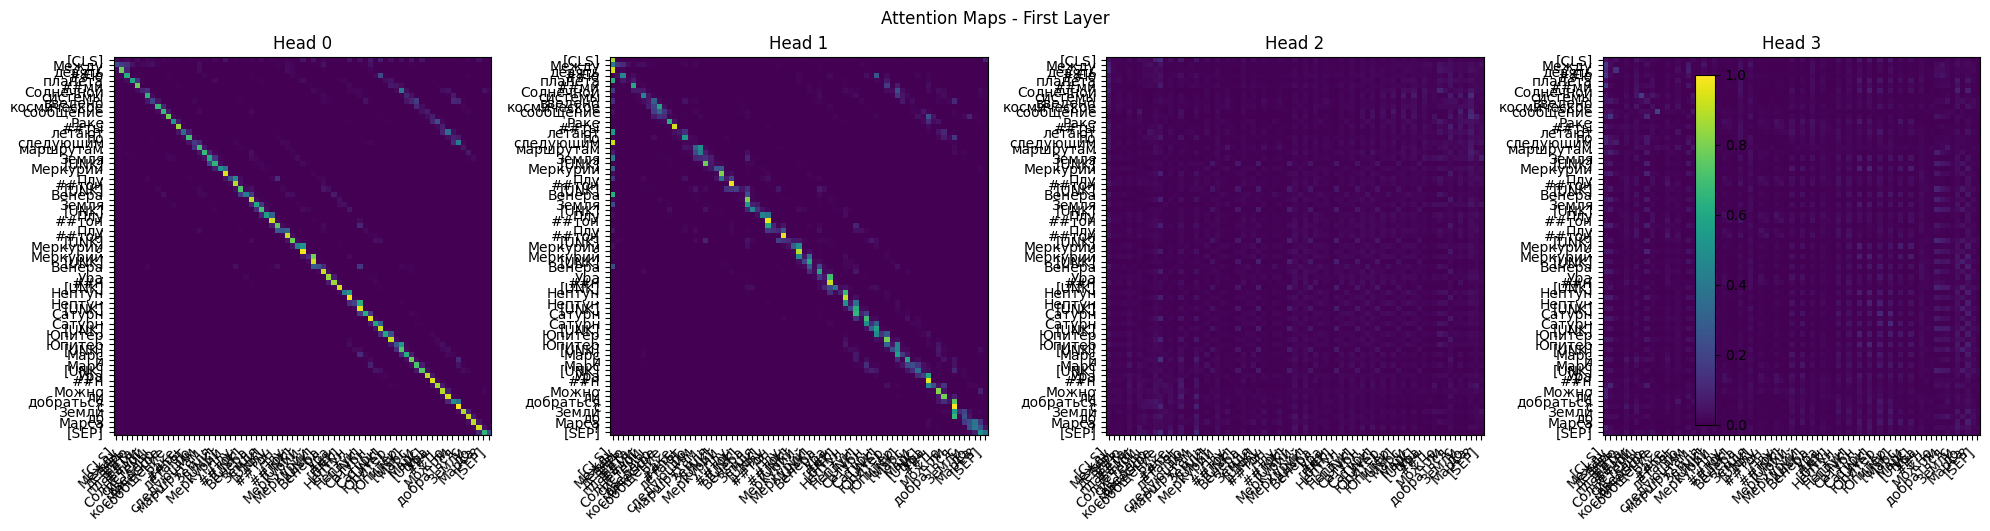


Text: В квадрате отметили 20 точек и соединили их непересекающимися отрезками друг с другом и с вершинами квадрата так, что квадрат разбился на треугольники. Сколько получилось треугольников? 


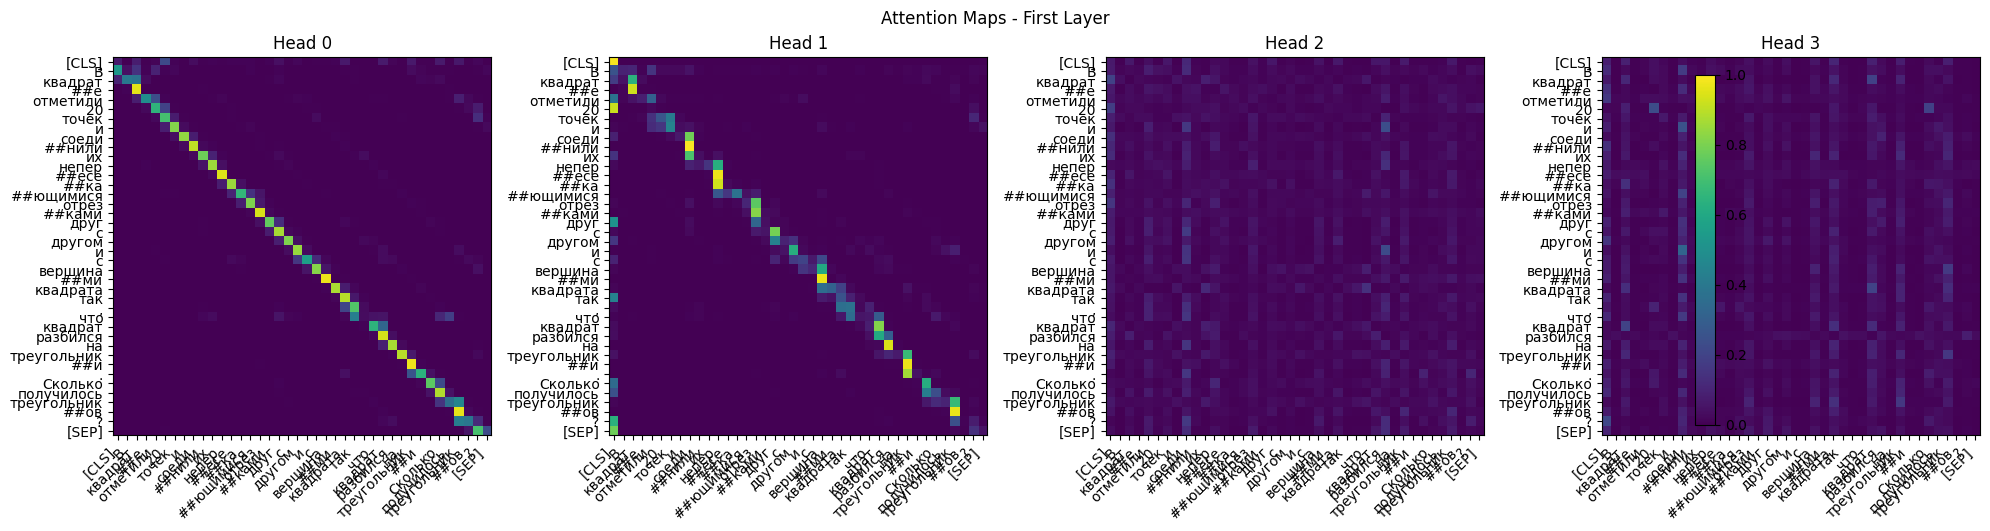


Text: Художник-авангардист нарисовал картину "Контур квадрата и его диагонали". 
Мог ли он нарисовать свою картину, не отрывая карандаша от бумаги и не проводя одну линию дважды? 


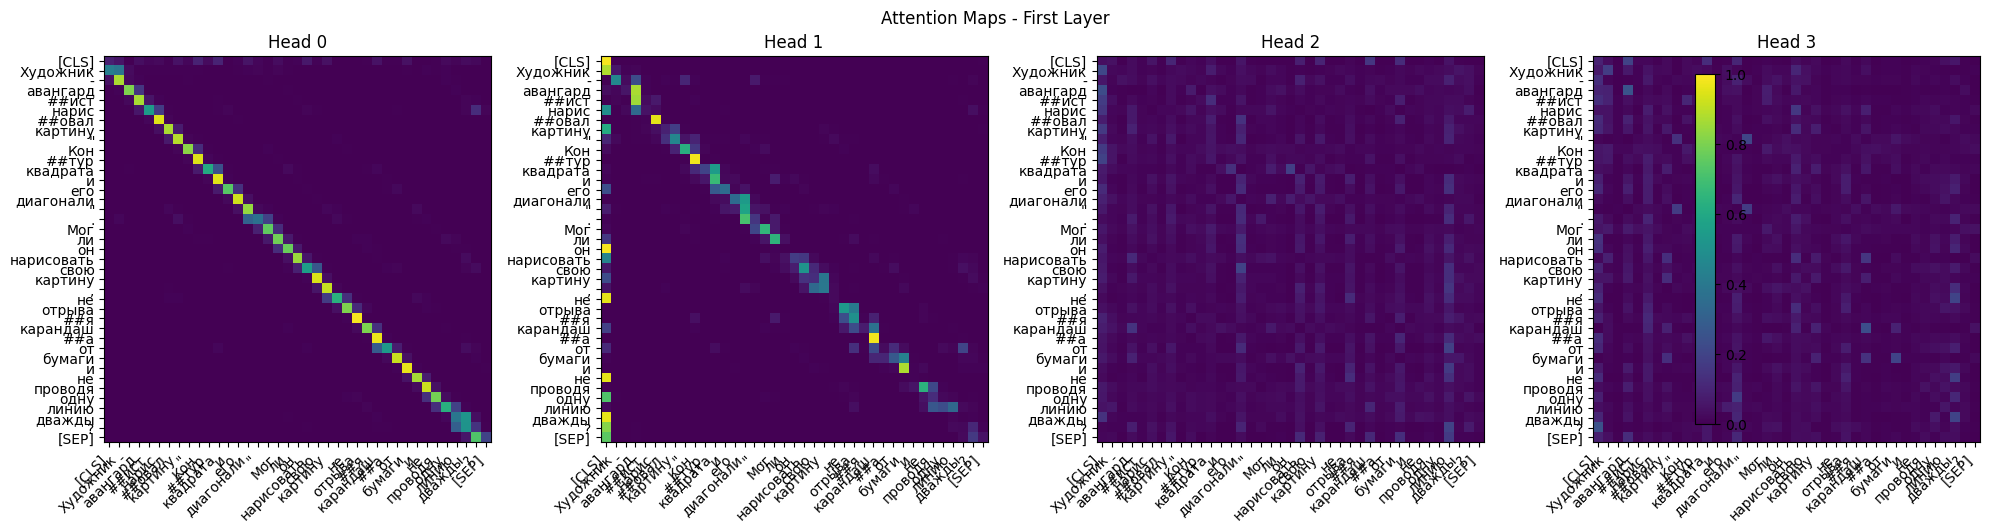


Fine-tuned MathBERT Attention Maps:
Text: Между девятью планетами Солнечной системы введено космическое сообщение.  Ракеты летают по следующим маршрутам: Земля – Меркурий, Плутон – Венера, Земля – Плутон, Плутон – Меркурий, Меркурий – Венера, Уран – Нептун, Нептун – Сатурн, Сатурн – Юпитер, Юпитер – Марс и Марс – Уран. Можно ли добраться с Земли до Марса? 


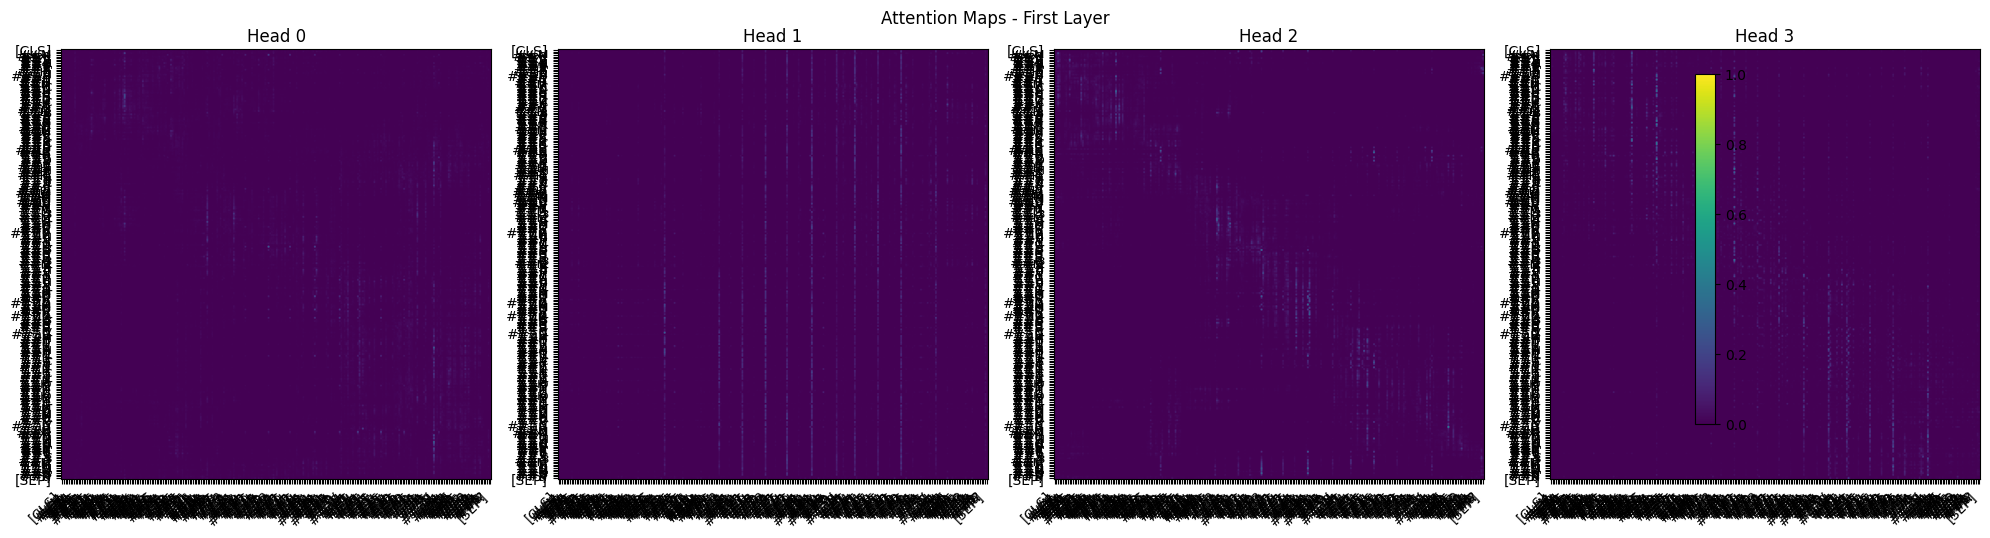


Text: В квадрате отметили 20 точек и соединили их непересекающимися отрезками друг с другом и с вершинами квадрата так, что квадрат разбился на треугольники. Сколько получилось треугольников? 


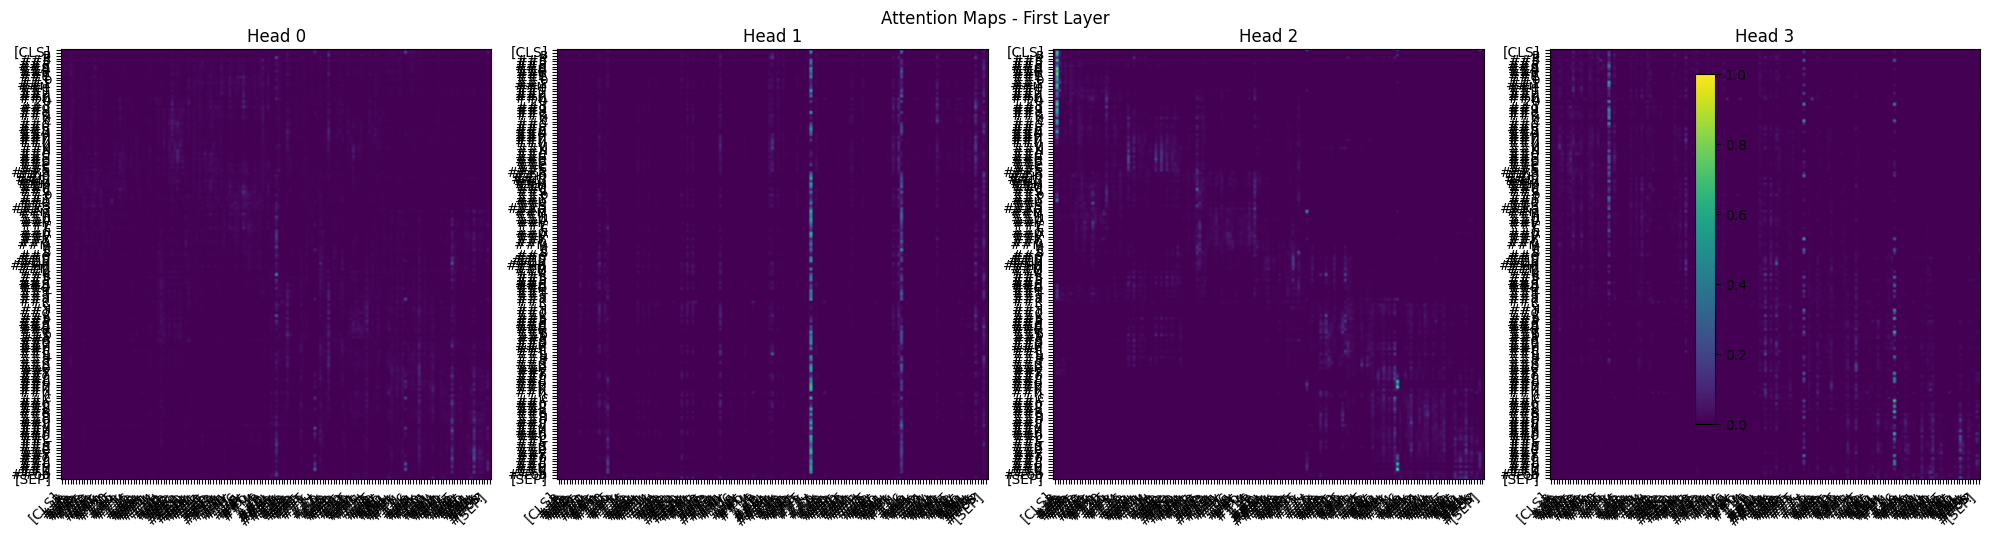


Text: Художник-авангардист нарисовал картину "Контур квадрата и его диагонали". 
Мог ли он нарисовать свою картину, не отрывая карандаша от бумаги и не проводя одну линию дважды? 


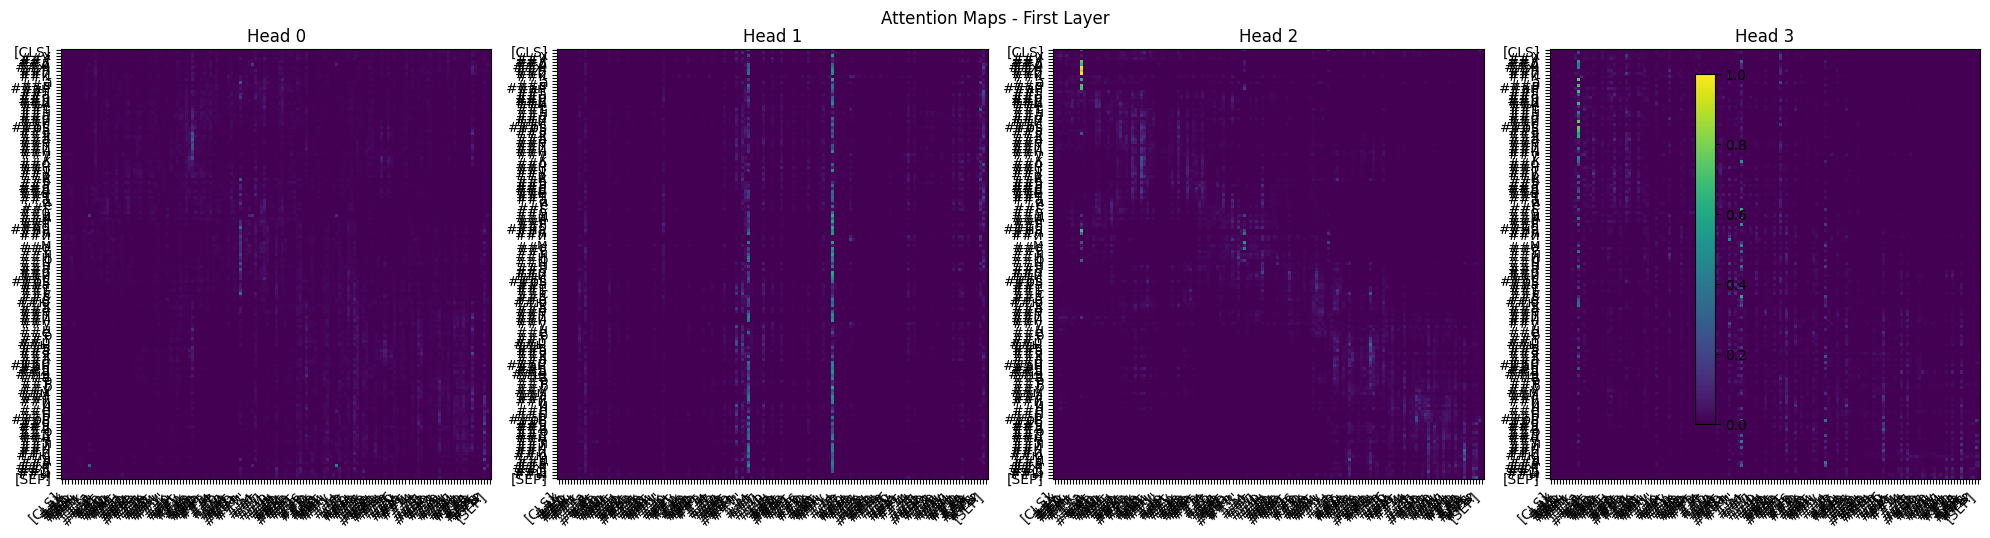

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Выбор нескольких текстов из датасета
texts = [
    data['Задача'][0],
    data['Задача'][100],
    data['Задача'][200]
]

# Идентификаторы голов внимания для отрисовки
attention_head_ids = [0, 1, 2, 3]

# Визуализация карт внимания для дообученной модели RuBERT-Tiny2
print("Fine-tuned RuBERT-Tiny2 Attention Maps:")
rubert_visualizer = AttentionMapVisualizer(rubert_tiny_full_finetuned)
for text in texts:
    print("Text:", text)
    rubert_visualizer.visualize_attention_maps(attention_head_ids, text, device)
    print()

# Визуализация карт внимания для дообученной модели MathBERT
print("Fine-tuned MathBERT Attention Maps:")
mathbert_visualizer = AttentionMapVisualizer(mathbert_full_finetuned)
for text in texts:
    print("Text:", text)
    mathbert_visualizer.visualize_attention_maps(attention_head_ids, text, device)
    print()